# Pré-traitement

In [157]:
#WARNINGS
import warnings
warnings.filterwarnings('ignore')

# NUMPY 
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN
import seaborn as sns

# SCIKIT-LEARN: SELECTION DE VARIABLES

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression

# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparer en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation : visulaisr des scores lors du choix d'un hyper-paramètre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper-paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage : visualisation des scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEURll
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import importlib

In [158]:
# import functions from data_preprocessing.py
import sys
import os

# Ajouter le chemin du dossier parent pour que Python puisse trouver le module 'data'
module_path = os.path.abspath(os.path.join('..'))
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    

from src import data_preprocessing
from data import extract_data


In [159]:
X = extract_data.X
y = extract_data.y

data = extract_data.data
df = data.copy()

df = data_preprocessing.fix_target_variable(df)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Education et education-num représentent la même information (la classe d'education de l'individu), on supprime alors le feature "education" pour éviter la duplication de l'information)

In [160]:
# suppression du colonne "education" car elle est redondante avec "education-num"
df.drop("education", axis=1, inplace=True)

## Donnée manquantes

In [161]:
miss_rates = (df.isna().sum() / df.shape[0])
miss_rates.sort_values(ascending=False)

occupation        0.019778
workclass         0.019717
native-country    0.005610
age               0.000000
fnlwgt            0.000000
education-num     0.000000
marital-status    0.000000
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
>=50k             0.000000
dtype: float64

Les features occupation , workclass  et native-country ont quelques valeurs manquantes 

In [162]:
df.isnull().sum().sort_values(ascending=False)

occupation        966
workclass         963
native-country    274
age                 0
fnlwgt              0
education-num       0
marital-status      0
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>=50k               0
dtype: int64

In [163]:
!pip install missingno

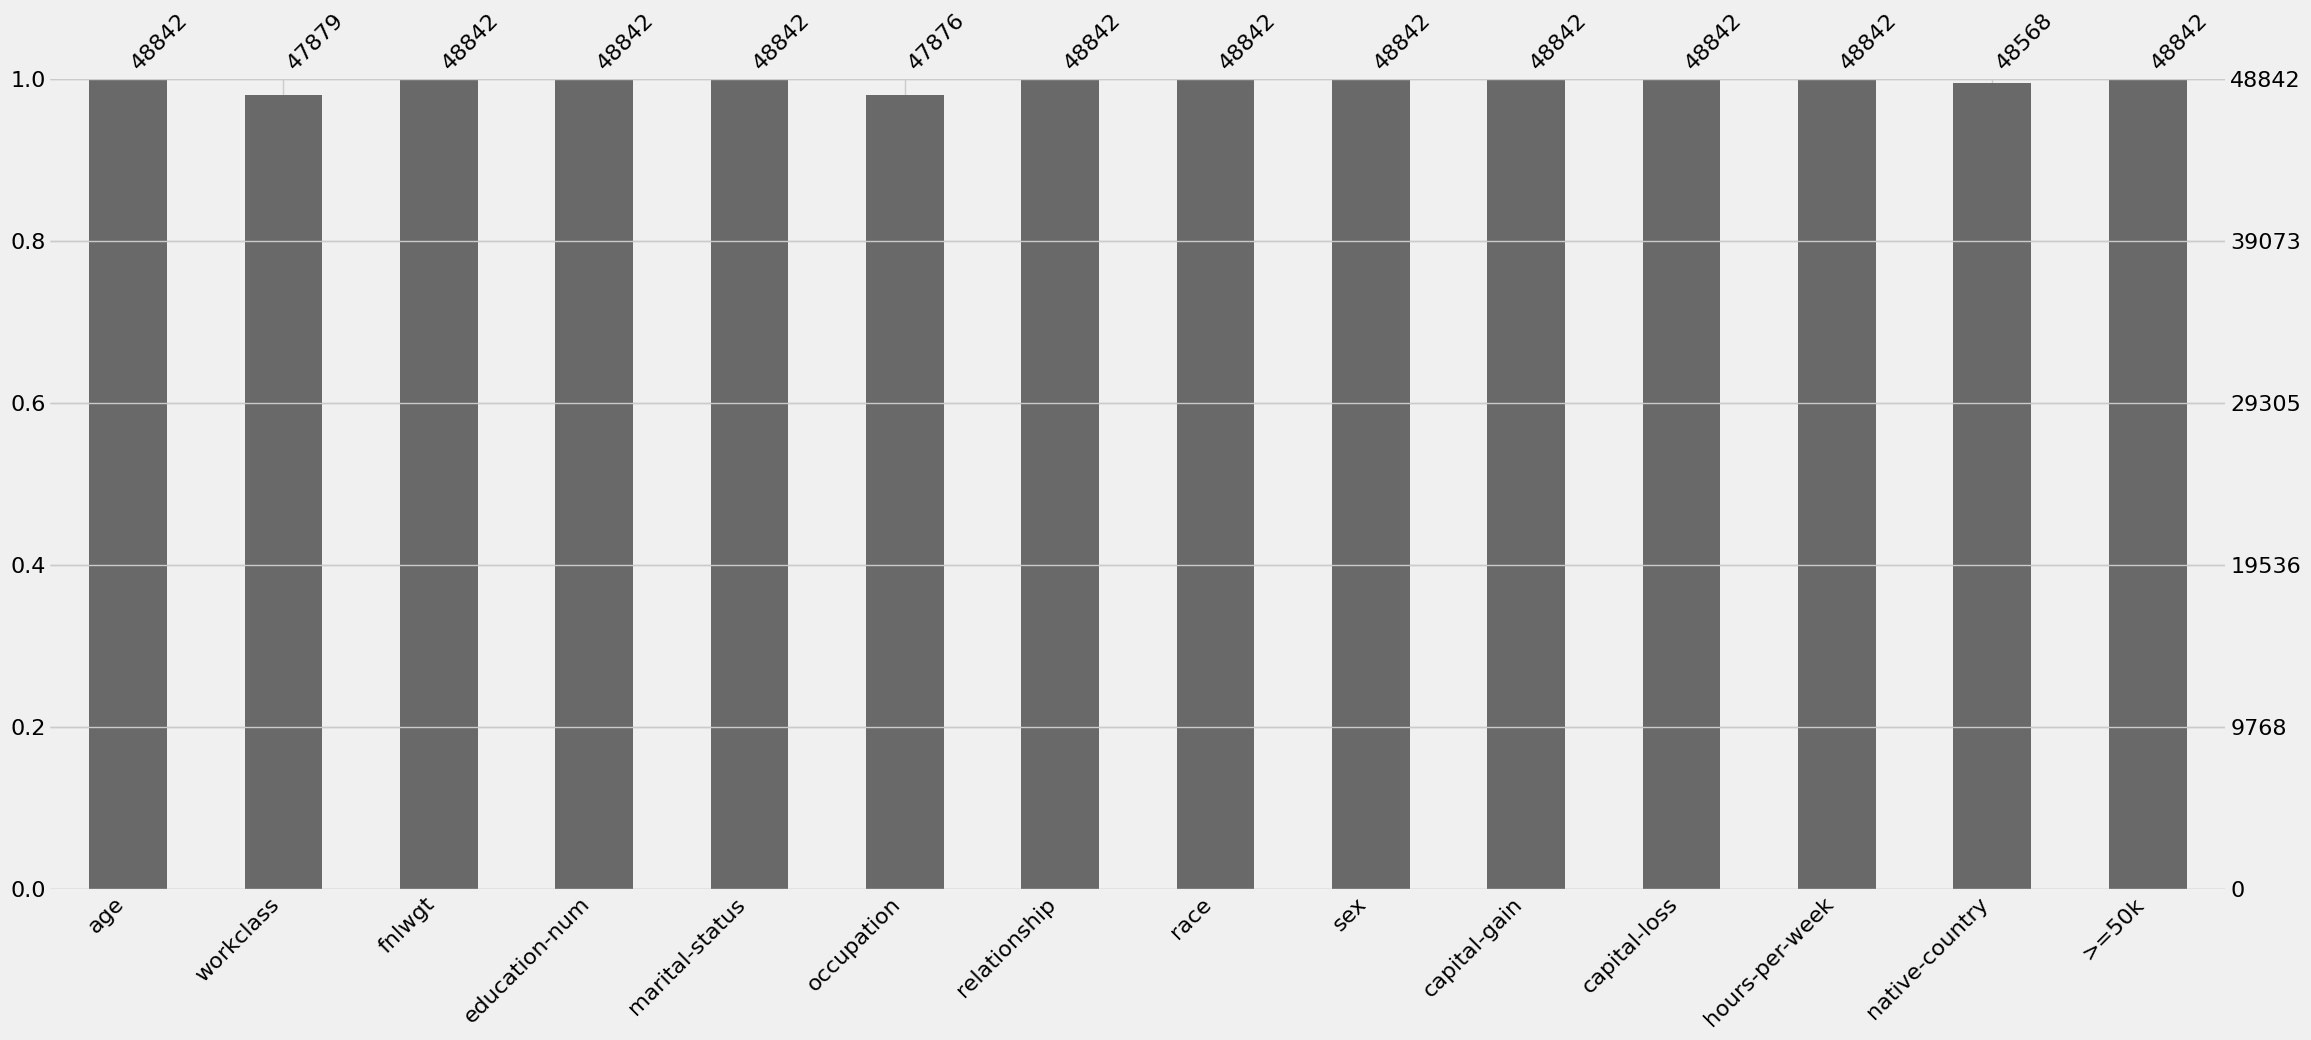

In [164]:
import missingno as msno
ax = msno.bar(df)

## Séparation en données train et test

Puisque les données sont déséquilibrés, nous utilisons la méthodes stratify qui nous permet de garantir que toutes les catégories de la variable cible seront présents dans les deux dataframes

In [165]:
importlib.reload(data_preprocessing)
df_train,df_test = data_preprocessing.seperate_train_test(df,random_state=7)
df_train.shape, df_test.shape

((39073, 14), (9769, 14))

In [166]:
# On vérifie l'existence de deux modalités dans le train et le test
print("Le nombre de modalité 0 dans train est: %s" %(df_train['>=50k'] == 0).sum())
print("Le nombre de modalité 1 dans train est: %s" %(df_train['>=50k'] == 1).sum())

print("Le nombre de modalité 0 dans test est: %s" %(df_test['>=50k'] == 0).sum())
print("Le nombre de modalité 1 dans test est: %s" %(df_test['>=50k'] == 1).sum())

Le nombre de modalité 0 dans train est: 29724
Le nombre de modalité 1 dans train est: 9349
Le nombre de modalité 0 dans test est: 7431
Le nombre de modalité 1 dans test est: 2338


Remarque : le déséquilibre des classes dans le jeu de données d'entraînement peut influencer les prédictions du modèle. le jeu de données contient beaucoup plus d'exemples de la classe 0 que de la classe 1, le modèle est alors biaisé et a une tendance à prédire la classe majoritaire (classe 0) plus souvent.

In [167]:
# transformer les types des features "age", capital-gain ,capital-loss ,hours-per-week  en float

df_train[['age', 'capital-gain', 'capital-loss', 'hours-per-week','fnlwgt']] = df_train[['age', 'capital-gain', 'capital-loss', 'hours-per-week','fnlwgt']].astype(float)
df_test[['age', 'capital-gain', 'capital-loss', 'hours-per-week','fnlwgt']] = df_test[['age', 'capital-gain', 'capital-loss', 'hours-per-week','fnlwgt']].astype(float)


In [168]:
df_train.dtypes

age               float64
workclass          object
fnlwgt            float64
education-num       int64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
>=50k               int64
dtype: object

In [169]:
cont_features = df_train.select_dtypes('float64').columns
cont_features

Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')

In [170]:
cat_features = df_train.select_dtypes('object').columns
# ajout de education-num dans cat_features
cat_features = cat_features.append(pd.Index(['education-num']))
cat_features

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'native-country', 'education-num'],
      dtype='object')

In [171]:
len(cont_features), len(cat_features)

(5, 8)

### Imputation des données manquantes

In [172]:
import importlib
importlib.reload(data_preprocessing)
df_train = data_preprocessing.impute_missing_cat_values(df_train, cat_features,"most_frequent")
df_test = data_preprocessing.impute_missing_cat_values(df_test, cat_features,"most_frequent")


In [173]:
# vérification des valeurs manquantes
df_train.isnull().sum().sort_values(ascending=False)


age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
>=50k             0
dtype: int64

## Outliers

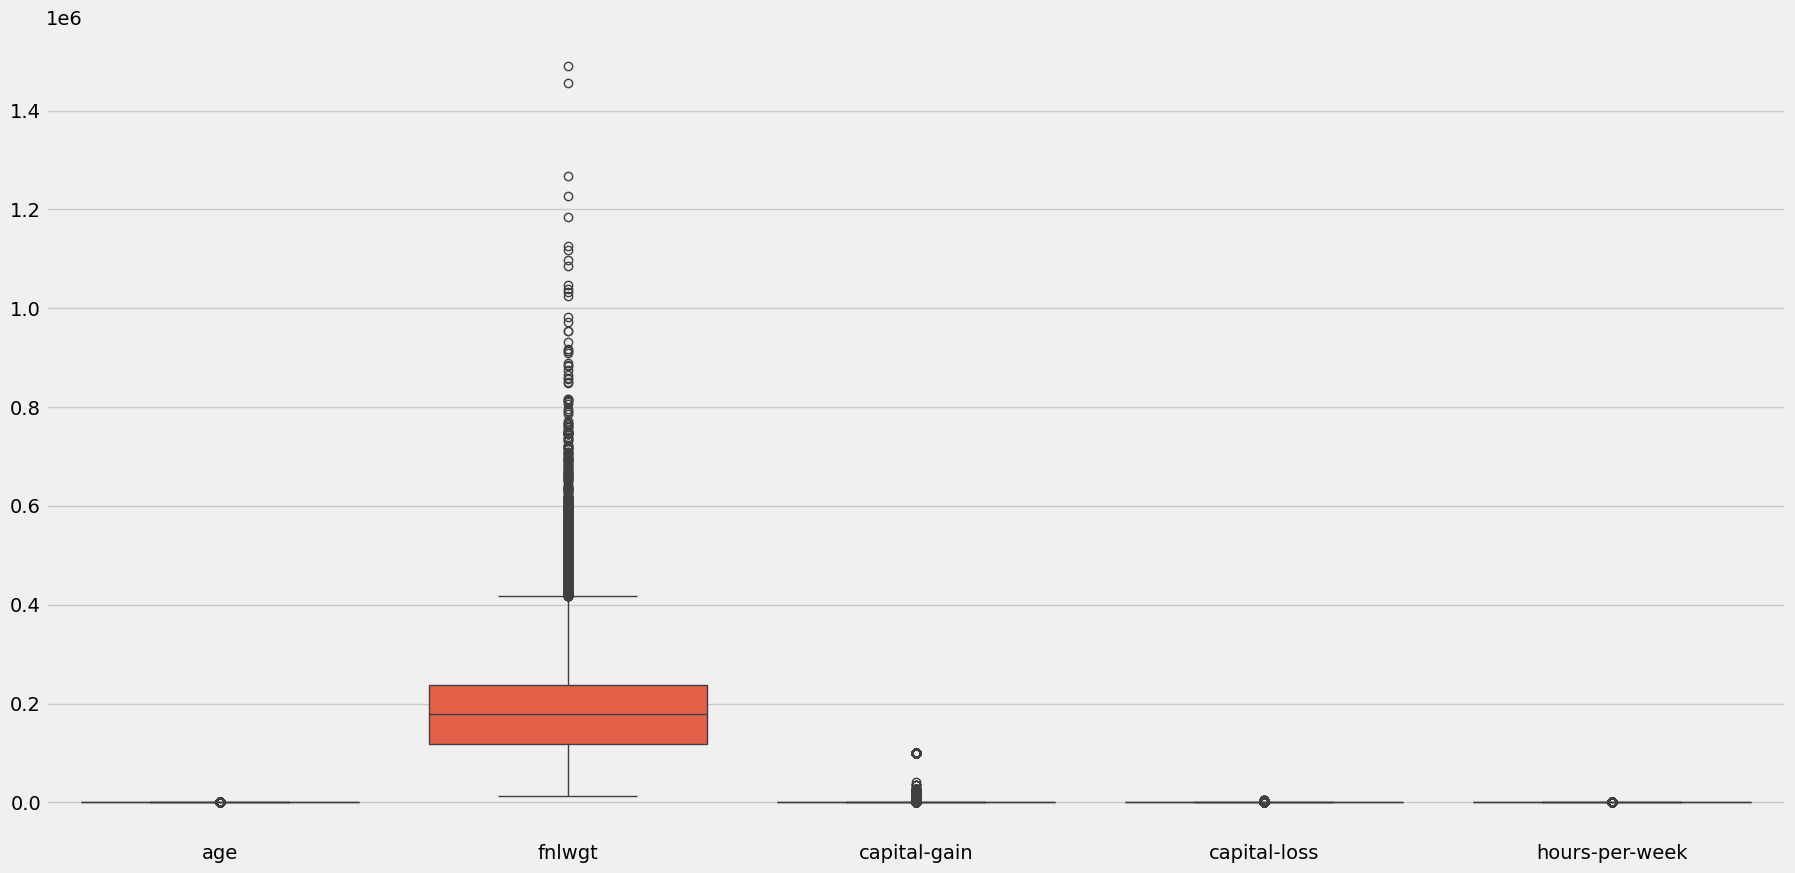

In [174]:
# affichage de boxplot pour les variables continues
plt.figure(figsize=(20,10))
sns.boxplot(data=df_train[cont_features])
plt.show()


Le feature 'fnlwgt' possede des valeurs aberrantes. Cependant le fait d'avoir de grandes valeurs du fnlwgt est bien pour la modelisation parceque il represente le plus grand nombre des individus dans la population finale . Donc, on laisse ces valeurs

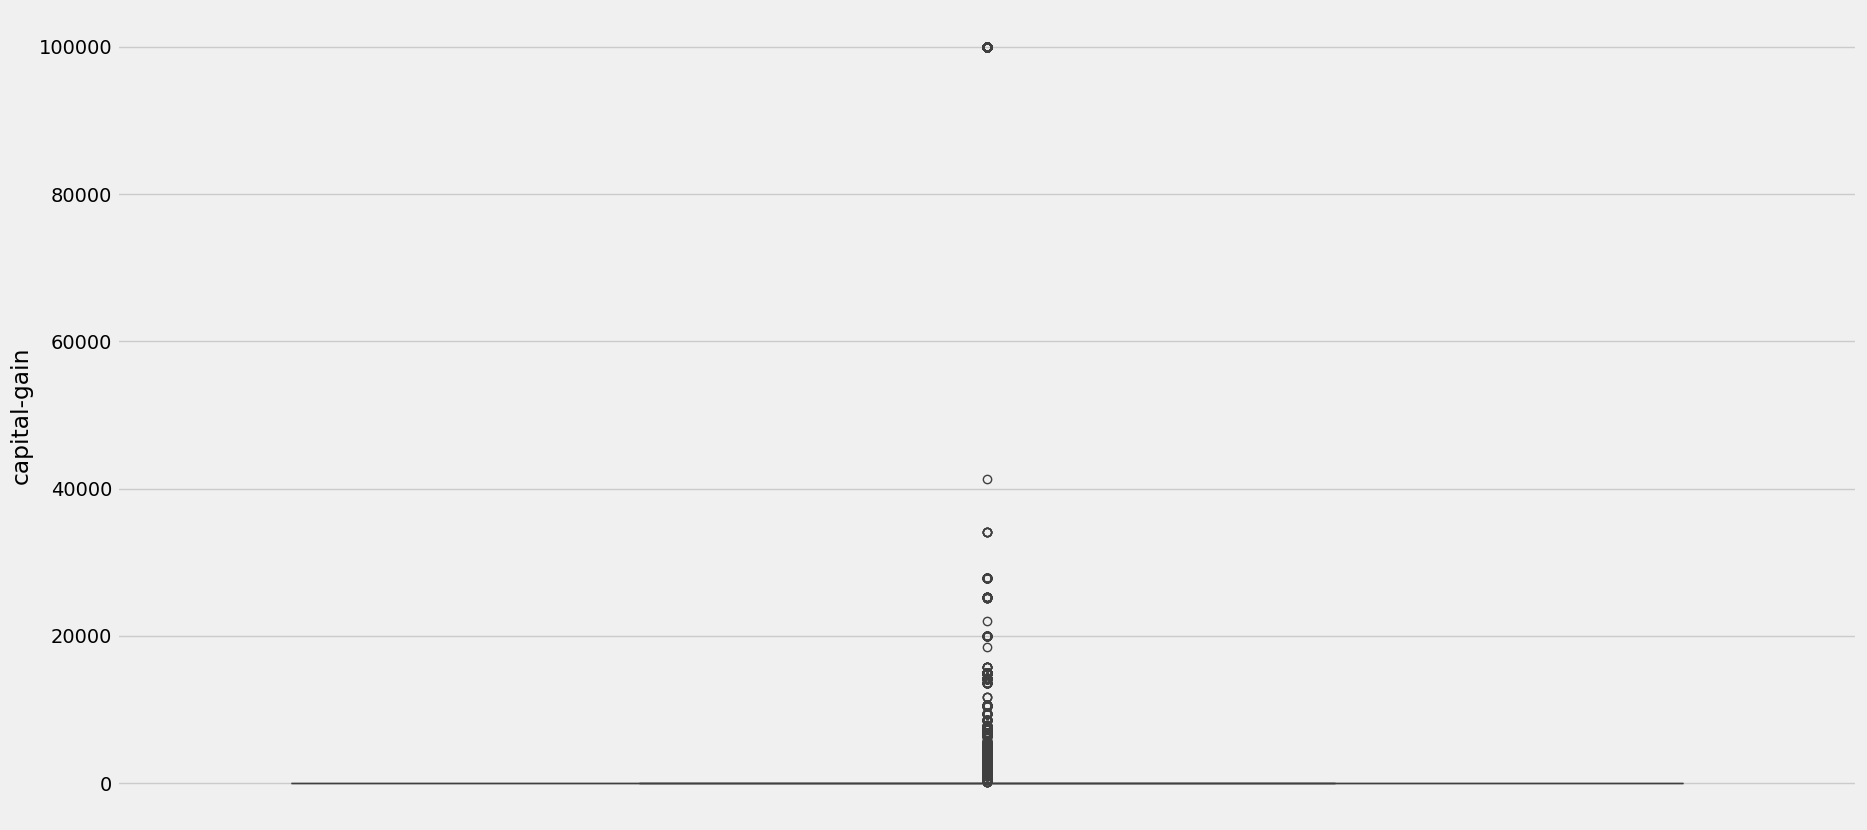

In [175]:
# boxplot pour capital-gain
plt.figure(figsize=(20,10))
sns.boxplot(data=df_train['capital-gain'])
plt.show()

In [176]:
df_train.shape

(39073, 14)

In [177]:
df_test.shape

(9769, 14)

In [179]:
df_train = df_train[df_train['capital-gain'] < 40000.]
df_test = df_test[df_test['capital-gain'] < 40000.]

In [180]:
df_train.shape

(38874, 14)

In [181]:
df_test.shape

(9721, 14)

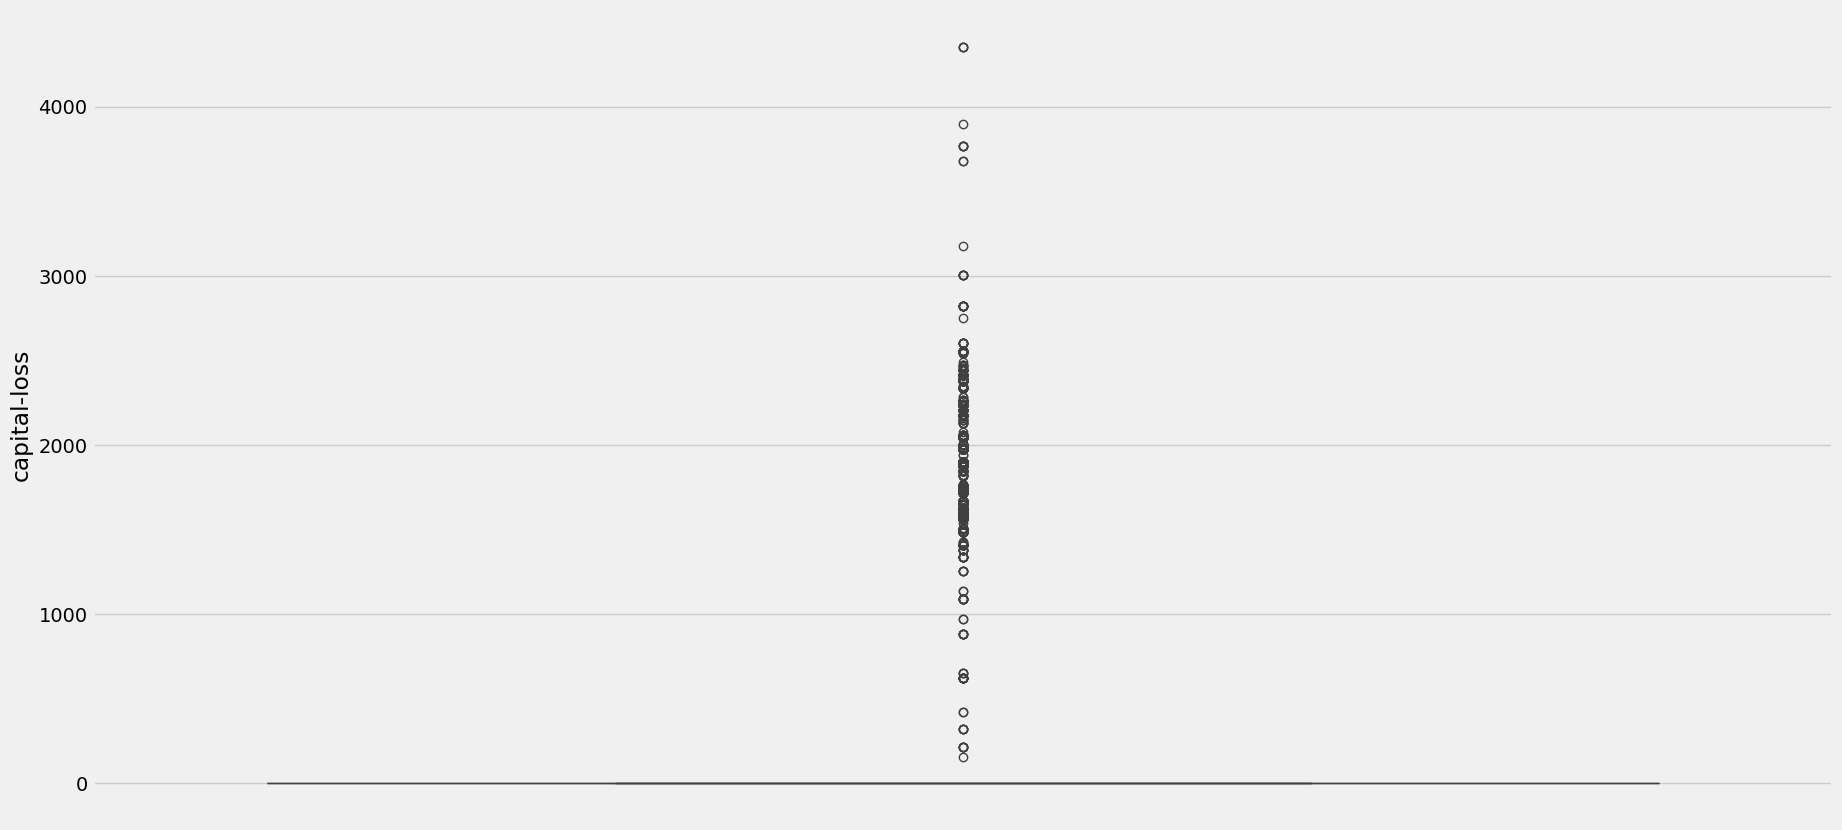

In [98]:
# boxplot pour capital-gain
plt.figure(figsize=(20,10))
sns.boxplot(data=df_train['capital-loss'])
plt.show()

In [185]:
df_train = df_train[df_train['capital-loss'] < 4000.]
df_test = df_test[df_test['capital-loss'] < 4000.]

In [186]:
df_train.shape

(36825, 14)

In [187]:
df_test.shape

(9184, 14)

## Traitement des variable quantitatives 

In [83]:
scaleStd = StandardScaler()
# scaleMinmax = MinMaxScaler()
for feature in cont_features:
    # Normaliser les données d'entrainement
    df_train[feature] = scaleStd.fit_transform(df_train[feature].values.reshape(-1,1))
    df_train[feature] = df_train[feature].ravel()
    # Normaliser les données test
    df_test[feature] = scaleStd.transform(df_test[feature].values.reshape(-1,1))
    df_test[feature] = df_test[feature].ravel()

## Traitement des variables qualitatives

In [75]:
encoder = LabelEncoder()
for feature in cat_features:
    df_train[feature] = encoder.fit_transform(df_train[feature])
    df_test[feature] = encoder.transform(df_test[feature])

In [76]:
df_train.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
34495,37.0,4,193106.0,12,4,12,1,4,0,0.0,0.0,30.0,39,0
18591,56.0,5,216636.0,7,2,4,0,4,1,0.0,1651.0,40.0,39,0
12562,53.0,4,126977.0,8,5,3,1,4,1,0.0,0.0,35.0,39,0
552,72.0,4,205343.0,6,6,1,4,4,0,0.0,0.0,40.0,39,0
3479,46.0,7,106705.0,13,4,4,1,4,0,0.0,0.0,38.0,39,0


In [77]:
df_test.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
40421,30.0,4,378009.0,8,4,7,3,4,1,0.0,0.0,40.0,39,0
47738,54.0,7,55861.0,11,0,1,1,4,1,0.0,0.0,39.0,39,0
518,21.0,0,204226.0,9,4,0,4,4,0,0.0,0.0,35.0,39,0
8564,35.0,4,306678.0,8,2,7,0,4,1,2885.0,0.0,40.0,39,0
31355,42.0,2,121012.0,9,2,4,0,4,1,0.0,0.0,45.0,39,1


## Sélection de variables

In [84]:
df_train_select = df_train.drop('>=50k', axis=1)
target_train = df_train['>=50k']

In [89]:
df_train.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
34495,-0.120090,4,0.029521,12,4,12,1,4,0,-0.144075,-0.216332,-0.844835,39,0
18591,1.268245,5,0.252606,7,2,4,0,4,1,-0.144075,3.898088,-0.038454,39,0
12562,1.049034,4,-0.597440,8,5,3,1,4,1,-0.144075,-0.216332,-0.441645,39,0
552,2.437369,4,0.145539,6,6,1,4,4,0,-0.144075,-0.216332,-0.038454,39,0
3479,0.537542,7,-0.789636,13,4,4,1,4,0,-0.144075,-0.216332,-0.199731,39,0


### Test de selectKbest

In [87]:
# Appliquer une sélection des variables et extraire 10 variables
df_train_select_withKbest = df_train_select.copy()
select = SelectKBest(score_func=chi2, k=10)
z = select.fit_transform(df_train_select_withKbest, target_train)

selection_scores = pd.DataFrame(select.scores_)
data_columns = pd.DataFrame(df_train_select.columns)

# Concaténer les deux dataframes
scores = pd.concat([data_columns, selection_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(11,'Score'))

ValueError: Input X must be non-negative.